In [2]:
import numpy as np
import tsplib95
from python_tsp.distances.tsplib_distance import tsplib_distance_matrix

cities = np.atleast_2d(list(tsplib95.load("data/xqf131.tsp").node_coords.values()))
distance_matrix = tsplib_distance_matrix("data/xqf131.tsp")


In [3]:
distance_matrix


array([[  0,  13,  14, ...,  88,  84, 108],
       [ 13,   0,   1, ...,  85,  86, 107],
       [ 14,   1,   0, ...,  85,  87, 107],
       ...,
       [ 88,  85,  85, ...,   0,  32,  25],
       [ 84,  86,  87, ...,  32,   0,  31],
       [108, 107, 107, ...,  25,  31,   0]])

In [4]:
cities

array([[  0,  13],
       [  0,  26],
       [  0,  27],
       [  0,  39],
       [  2,   0],
       [  5,  13],
       [  5,  19],
       [  5,  25],
       [  5,  31],
       [  5,  37],
       [  5,  43],
       [  5,   8],
       [  8,   0],
       [  9,  10],
       [ 10,  10],
       [ 11,  10],
       [ 12,  10],
       [ 12,   5],
       [ 15,  13],
       [ 15,  19],
       [ 15,  25],
       [ 15,  31],
       [ 15,  37],
       [ 15,  43],
       [ 15,   8],
       [ 18,  11],
       [ 18,  13],
       [ 18,  15],
       [ 18,  17],
       [ 18,  19],
       [ 18,  21],
       [ 18,  23],
       [ 18,  25],
       [ 18,  27],
       [ 18,  29],
       [ 18,  31],
       [ 18,  33],
       [ 18,  35],
       [ 18,  37],
       [ 18,  39],
       [ 18,  41],
       [ 18,  42],
       [ 18,  44],
       [ 18,  45],
       [ 25,  11],
       [ 25,  15],
       [ 25,  22],
       [ 25,  23],
       [ 25,  24],
       [ 25,  26],
       [ 25,  28],
       [ 25,  29],
       [ 25,

In [5]:
from python_tsp.heuristics import solve_tsp_simulated_annealing

distance_matrix = tsplib_distance_matrix("data/xqf131.tsp")

permutation, distance = solve_tsp_simulated_annealing(distance_matrix)
print(distance)
print(permutation)

622
[0, 13, 11, 4, 12, 17, 24, 18, 16, 15, 14, 19, 31, 30, 29, 28, 27, 26, 25, 44, 52, 45, 53, 54, 63, 73, 88, 76, 67, 74, 77, 80, 81, 86, 91, 93, 98, 92, 97, 99, 100, 101, 105, 104, 111, 113, 117, 120, 122, 129, 130, 126, 125, 124, 123, 112, 106, 107, 108, 114, 118, 109, 110, 116, 119, 115, 127, 128, 121, 102, 103, 96, 95, 94, 90, 89, 87, 82, 83, 85, 84, 79, 78, 69, 75, 70, 66, 62, 65, 68, 64, 61, 46, 47, 48, 49, 50, 51, 55, 56, 57, 58, 71, 72, 59, 60, 43, 42, 23, 41, 40, 39, 22, 38, 37, 36, 21, 35, 34, 33, 32, 20, 8, 9, 10, 3, 2, 1, 7, 6, 5]


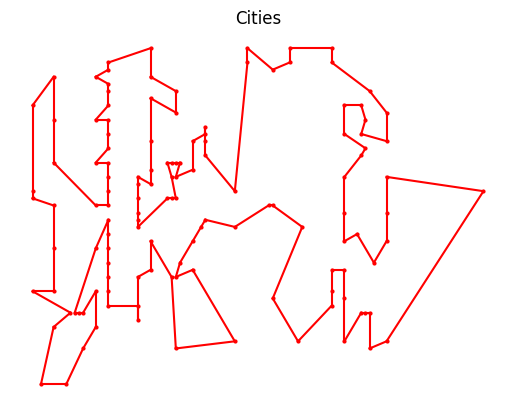

In [6]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.title("Cities")

plt.plot(cities[:, 0], cities[:,1], 'or', markersize=2)

for i in range(len(permutation) - 1):
    plt.plot(cities[[permutation[i], permutation[i+1]], 0], cities[[permutation[i], permutation[i+1]], 1], c="r")

plt.plot(cities[[permutation[len(cities) - 1], 0], 0], cities[[permutation[len(cities) - 1], 0], 1], c="r")

plt.show()

In [28]:
from sklearn.cluster import KMeans

N_CLUSTERS = 10

kmeans = KMeans(n_clusters=N_CLUSTERS).fit(cities)
print(kmeans.labels_)

LABELS = list(kmeans.labels_)
CENTROIDS = np.atleast_2d(kmeans.cluster_centers_)

[4 7 7 7 4 4 4 7 7 7 7 4 4 4 4 4 4 4 4 1 1 1 8 8 4 4 4 1 1 1 1 1 1 1 1 1 8
 8 8 8 8 8 8 8 6 6 1 1 1 1 1 1 6 6 6 5 5 5 8 8 8 5 5 6 5 5 5 6 5 5 5 5 5 6
 6 5 6 6 5 5 5 5 5 5 5 5 0 0 0 9 9 0 0 0 9 9 9 2 0 2 2 2 3 3 2 2 2 2 3 3 3
 2 2 2 3 3 3 2 3 3 2 3 2 2 2 3 3 3 3 2 3]


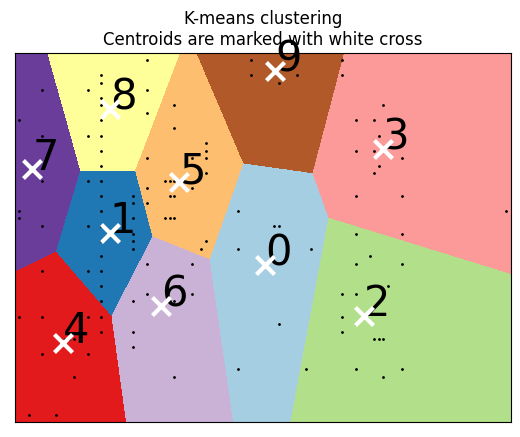

In [29]:
import matplotlib.pyplot as plt

# reduced_data = PCA(n_components=2).fit_transform(data)
# kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
# kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = cities[:, 0].min() - 1, cities[:, 0].max() + 1
y_min, y_max = cities[:, 1].min() - 1, cities[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(cities[:, 0], cities[:, 1], "k.", markersize=2)
# Plot the centroids as a white X

plt.scatter(
    CENTROIDS[:, 0],
    CENTROIDS[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

for idx, c in enumerate(CENTROIDS):
    plt.annotate(idx, c, fontsize = 30)

plt.title(
    "K-means clustering\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [24]:
from python_tsp.distances.euclidean_distance import euclidean_distance_matrix

subproblems = []

for i in range(N_CLUSTERS):
    problem = np.atleast_2d([city for idx, city in enumerate(cities) if kmeans.labels_[idx] == i])
    subproblems.append(problem)

CLUSTERS = []
for p in subproblems:
    distance_matrix = euclidean_distance_matrix(p)
    permutation, distance = solve_tsp_simulated_annealing(distance_matrix)
    print(distance)
    subset = np.atleast_2d([p[x] for x in permutation])
    print(subset)
    CLUSTERS.append(subset)


98.47141480120607
[[ 74  29]
 [ 78  32]
 [ 79  33]
 [ 78  35]
 [ 74  35]
 [ 74  39]
 [ 78  39]
 [ 79  37]
 [ 80  41]
 [ 84  38]
 [ 84  34]
 [ 84  29]
 [107  27]
 [ 84  24]]
53.99625865228415
[[15 19]
 [18 17]
 [18 15]
 [25 22]
 [25 23]
 [25 24]
 [25 26]
 [25 28]
 [25 29]
 [18 31]
 [15 31]
 [18 29]
 [18 27]
 [15 25]
 [18 25]
 [18 23]
 [18 21]
 [18 19]]
64.43669027186418
[[40 22]
 [48  6]
 [57 12]
 [57 25]
 [56 25]
 [48 27]
 [48 22]
 [41 23]]
67.51536971346104
[[ 5 43]
 [15 37]
 [18 33]
 [18 35]
 [18 37]
 [18 39]
 [28 40]
 [28 43]
 [28 47]
 [18 45]
 [18 44]
 [18 42]
 [18 41]
 [15 43]]
96.73347694796152
[[63  6]
 [74  6]
 [80  5]
 [84  6]
 [80 10]
 [79 10]
 [78 10]
 [74 12]
 [74 16]
 [81 17]
 [84 20]
 [77 21]
 [74 20]
 [74 24]
 [64 22]
 [71 16]
 [71 13]
 [71 11]]
58.74611785597371
[[ 0 13]
 [ 5  8]
 [ 2  0]
 [ 8  0]
 [12  5]
 [15  8]
 [18 11]
 [18 13]
 [15 13]
 [12 10]
 [11 10]
 [10 10]
 [ 9 10]
 [ 5 13]]
53.95798285038099
[[28 28]
 [28 30]
 [28 34]
 [34 41]
 [34 38]
 [38 34]
 [41 36]
 [4

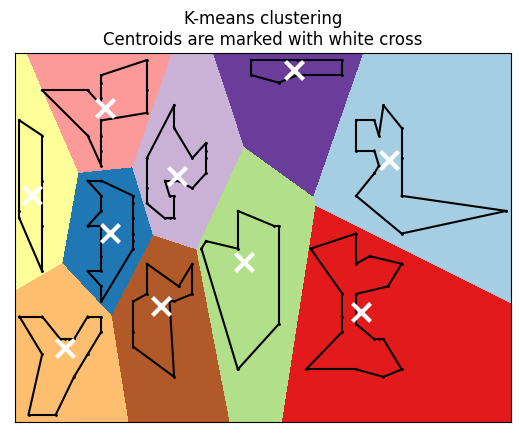

In [25]:
from math import dist

h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = cities[:, 0].min() - 1, cities[:, 0].max() + 1
y_min, y_max = cities[:, 1].min() - 1, cities[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(cities[:, 0], cities[:, 1], "k.", markersize=2)

for cluster in CLUSTERS:
    for i in range(len(cluster) - 1):
        plt.plot(cluster[[i, i+1], 0], cluster[[i, i+1], 1], c="k")
    plt.plot(cluster[[len(cluster) - 1, 0], 0], cluster[[len(cluster) - 1, 0], 1], c="k")

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

plt.title(
    "K-means clustering\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [57]:
def concatenate_clusters(cluster_a: np.ndarray, cluster_b: np.ndarray, centroid_a: np.ndarray, centroid_b: np.ndarray) -> (np.ndarray, np.ndarray):
    
    def get_closest_points(cluster, centroid):

        distances = []
        for point in cluster:
            distances.append((point, dist(point, centroid)))
        distances.sort(key=lambda x: x[1])
        p1 = distances[0][0]

        idx1 = [idx for idx, x in enumerate(cluster) if x[0] == p1[0] and x[1] == p1[1]][0]

        forward = idx1 + 1
        if forward >= len(cluster):
            forward = 0
        backward = idx1 - 1

        new_perm = list(cluster)

        if dist(cluster[forward], centroid) < dist(cluster[backward], centroid):
            p2 = cluster[forward]
            idx2 = forward
            new_perm = new_perm[idx1::-1] + new_perm[:idx2 - 1:-1]
        else:
            p2 = cluster[backward]
            idx2 = backward
            new_perm = new_perm[idx1:] + new_perm[:idx2 + 1]

        return p1, p2, np.atleast_2d(new_perm)
    
    p1, p2, new_cluster_a = get_closest_points(cluster_a, centroid_b)
    p3, p4, new_cluster_b = get_closest_points(cluster_b, centroid_a)
    
    def ccw(A,B,C):
        return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

    # Return true if line segments AB and CD intersect
    def intersect(A,B,C,D):
        return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)
    
    result = new_cluster_a

    if intersect(p1, p3, p2, p4):
        result += new_cluster_b
    else:
        result = np.concatenate((result, np.flip(new_cluster_b, 0)), axis=0)

    def get_centeroid(arr):
        x = np.mean(arr[:, 0])
        y = np.mean(arr[:, 1])
        return x, y
    
    return result, get_centeroid(result)

In [58]:
concatenate_clusters(CLUSTERS[0], CLUSTERS[2], CENTROIDS[0], CENTROIDS[2])

[[ 84  24]
 [107  27]
 [ 84  29]
 [ 84  34]
 [ 84  38]
 [ 80  41]
 [ 79  37]
 [ 78  39]
 [ 74  39]
 [ 74  35]
 [ 78  35]
 [ 79  33]
 [ 78  32]
 [ 74  29]]
[[ 84  24]
 [107  27]
 [ 84  29]
 [ 84  34]
 [ 84  38]
 [ 80  41]
 [ 79  37]
 [ 78  39]
 [ 74  39]
 [ 74  35]
 [ 78  35]
 [ 79  33]
 [ 78  32]
 [ 74  29]
 [ 57  25]
 [ 57  12]
 [ 48   6]
 [ 40  22]
 [ 41  23]
 [ 48  22]
 [ 48  27]
 [ 56  25]]


(array([[ 84,  24],
        [107,  27],
        [ 84,  29],
        [ 84,  34],
        [ 84,  38],
        [ 80,  41],
        [ 79,  37],
        [ 78,  39],
        [ 74,  39],
        [ 74,  35],
        [ 78,  35],
        [ 79,  33],
        [ 78,  32],
        [ 74,  29],
        [ 57,  25],
        [ 57,  12],
        [ 48,   6],
        [ 40,  22],
        [ 41,  23],
        [ 48,  22],
        [ 48,  27],
        [ 56,  25]]),
 (69.63636363636364, 28.818181818181817))

In [89]:
# cost = 0
# for i in range(len(seq_res) - 1):
#     cost += dist(seq_res[i], seq_res[i + 1])
# cost += dist(seq_res[-1], seq_res[0])
# print(cost)

626.172668499614
